# Importing necessary libraries

In [1]:
#import necessary libraries
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re

In [2]:
data = pd.read_csv(r'E:\Sentiment.csv')

# EDA

In [3]:
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [4]:
data.shape

(13871, 21)

In [5]:
#Getting all the columns of business dataset
print("Features of the sentiment dataset:")
data.columns

Features of the sentiment dataset:


Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
#print the unique value of sentiment data
print('The unique numbers in the sentiment data are as follow :')
data.nunique()

The unique numbers in the sentiment data are as follow :


id                           13871
candidate                       11
candidate_confidence           986
relevant_yn                      1
relevant_yn_confidence         508
sentiment                        3
sentiment_confidence          1153
subject_matter                  12
subject_matter_confidence     1429
candidate_gold                   9
name                          9829
relevant_yn_gold                 1
retweet_count                  493
sentiment_gold                   4
subject_matter_gold             10
text                         10402
tweet_coord                     20
tweet_created                 8748
tweet_id                     13837
tweet_location                4288
user_timezone                  110
dtype: int64

In [7]:
#check details about the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-null     obj

In [8]:
#check for count of missing values in each column of sentiment data
print('The null values present in the sentiment data are :')
data.isna().sum()
data.isnull().sum()

The null values present in the sentiment data are :


id                               0
candidate                       96
candidate_confidence             0
relevant_yn                      0
relevant_yn_confidence           0
sentiment                        0
sentiment_confidence             0
subject_matter                 326
subject_matter_confidence        0
candidate_gold               13843
name                             0
relevant_yn_gold             13839
retweet_count                    0
sentiment_gold               13856
subject_matter_gold          13853
text                             0
tweet_coord                  13850
tweet_created                    0
tweet_id                         0
tweet_location                3912
user_timezone                 4403
dtype: int64

c:\program files\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


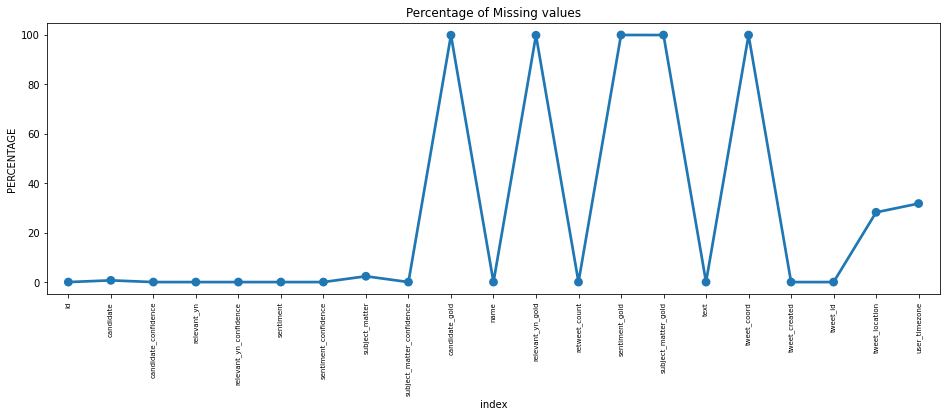

In [9]:
#plot the graph to check wether there are any missing value present
missing = pd.DataFrame((data.isnull().sum())*100/data.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot('index',0,data=missing)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

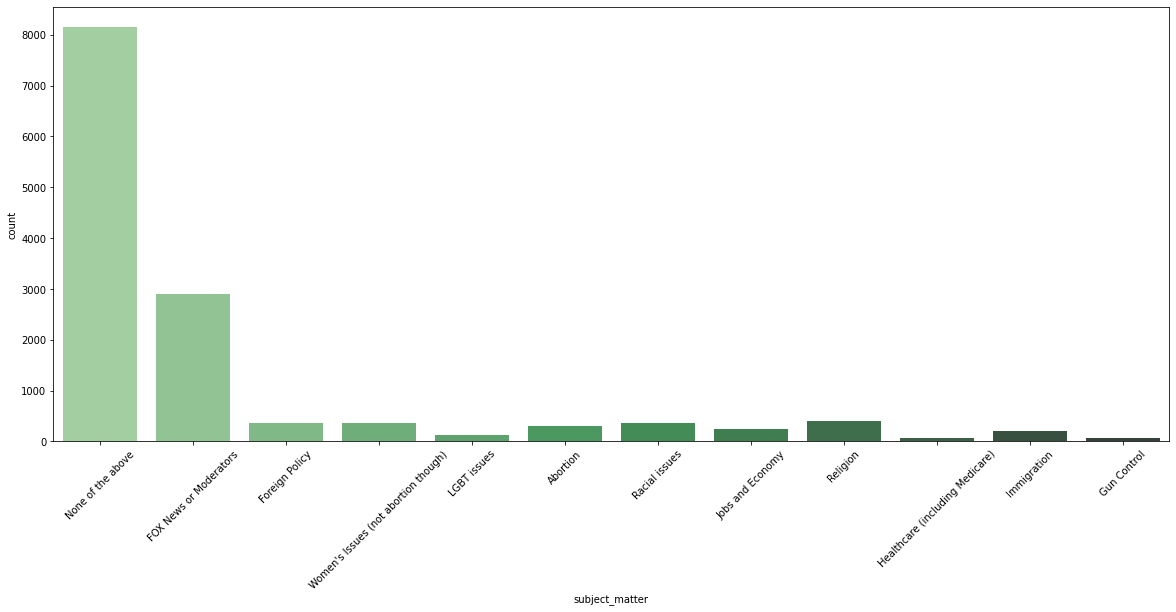

In [10]:
#Here we are just controlling the size of the grid and the orientation of the labels in the x-axis
plt.figure(figsize=(20, 8))
plt.xticks(rotation=45)

sns.countplot(x="subject_matter", data=data, palette="Greens_d");

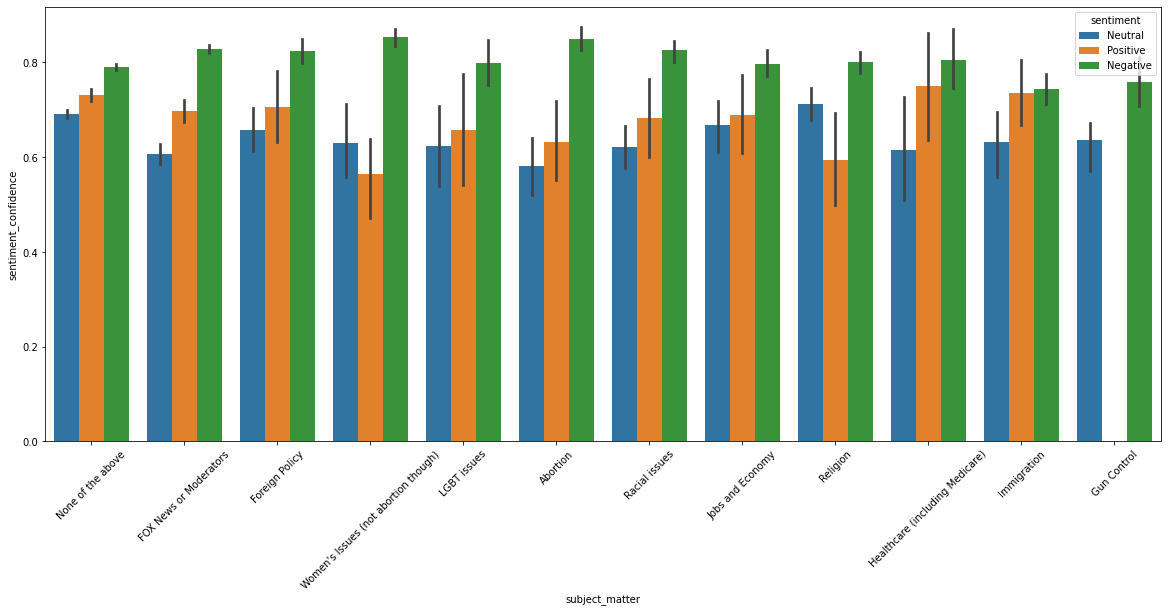

In [11]:
#Lets look into the sentiment distribution through all the topics.
plt.figure(figsize=(20, 8))
plt.xticks(rotation=45)

sns.barplot(x="subject_matter", y="sentiment_confidence", hue="sentiment", data=data);

# Preprocessing

In [12]:
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [13]:
# data preview
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


Next, I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain. Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [14]:
#dropping of neutral sentiment 
data = data[data.sentiment != "Neutral"]

In [15]:
data['sentiment'].value_counts()

Negative    8493
Positive    2236
Name: sentiment, dtype: int64

In [16]:
# converting the text column into lower case
data['text'] = data['text'].apply(lambda x: x.lower())
# removing special chars
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#
data.head()

,text,sentiment
1,rt scottwalker didnt catch the full gopdebate ...,Positive
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive
5,rt gregabbott_tx tedcruz on my first day i wil...,Positive
6,rt warriorwoman91 i liked her and was happy wh...,Negative


In [17]:
# Now tokenizing the text column    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
X[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    3,
         360,  121,    1,  694,    2,   40,   59,  235,   38,  208,    7,
         173, 1747,   13, 1310, 1394,  735],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    3,
          17,  282,  250,    6,  811,  103,  171,   27,  135,    7,    1,
         172,   13,    2,  232,  715,   18]])

Next, I compose the LSTM Network. Note that embed_dim, lstm_out, batch_size, droupout_x variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [18]:
#Hereby I declare the train and test dataset.
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8583, 28) (8583, 2)
(2146, 28) (2146, 2)


In [19]:
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

# Modelling

In [20]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 28, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1)

Epoch 1/15
68/68 [==============================] - 21s 215ms/step - loss: 0.4646 - accuracy: 0.7995
Epoch 2/15
68/68 [==============================] - 14s 201ms/step - loss: 0.3309 - accuracy: 0.8611
Epoch 3/15
68/68 [==============================] - 14s 205ms/step - loss: 0.2869 - accuracy: 0.8817
Epoch 4/15
68/68 [==============================] - 14s 200ms/step - loss: 0.2667 - accuracy: 0.8891
Epoch 5/15
68/68 [==============================] - 14s 199ms/step - loss: 0.2490 - accuracy: 0.8972
Epoch 6/15
68/68 [==============================] - 14s 208ms/step - loss: 0.2350 - accuracy: 0.9038
Epoch 7/15
68/68 [==============================] - 14s 204ms/step - loss: 0.2110 - accuracy: 0.9137
Epoch 8/15
68/68 [==============================] - 14s 205ms/step - loss: 0.1978 - accuracy: 0.9170
Epoch 9/15
68/68 [==============================] - 13s 192ms/step - loss: 0.1881 - accuracy: 0.9231
Epoch 10/15
68/68 [==============================] - 12s 184ms/step - loss: 0.1731 - accura

Extracting a validation set, and measuring score and accuracy.

In [22]:
# Y_pred = model.predict(X_test,batch_size = batch_size)

In [23]:
from tensorflow.keras.models import Model

In [24]:
final_model= Model.save(model,"C:/Users/YMTS0513/Sentiment Analysis Using LSTM/model.h5")

# Prediction

In [28]:
twt = ['i have written this code ']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)
print(twt)
from tensorflow import keras
model = keras.models.load_model('C:/Users/YMTS0513/Sentiment Analysis Using LSTM/model.h5')
sentiment =model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0  10  29  21 507]]
1/1 - 0s
positive
